**Nuclei segmentation in whole slide H&E images**

using custom model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [2]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
import os
from glob import glob

pth = r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\mouse_brain_slide_test'  # path of ndpi files
WSIs = sorted(glob(r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\mouse_brain_slide_test\*.ndpi'))

In [4]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)

    offset = 1024/4 + 1024/8
    crop_width = 256
    crop_height = 256
    crop_x = int(data['crop_x']*ratio + offset)
    crop_y = int(data['crop_y']*ratio)

    return (crop_x, crop_y, crop_width)

In [5]:
WSIs[0]

'\\\\10.99.68.178\\andreex\\students\\Donald Monkey fetus\\stardist\\mouse_brain_slide_test\\FXFAD12FB2_0467.ndpi'

Run next cell if you have lots of memory and want to store multiple ndpis in RAM --> so probably don't run

Load just 1 20x image in RAM below

In [6]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 0  # which image in directory list you are loading

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

img = img/255

In [7]:
crop_x = 8000
crop_y = 16000
tile_size = 1024

In [10]:
show_image(img, crop_x, crop_y, tile_size)

MemoryError: Unable to allocate 32.1 GiB for an array with shape (29568, 36480, 4) and data type float64

<Figure size 1600x800 with 2 Axes>

In [8]:
import json
from stardist.models import Config2D, StarDist2D

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

model = load_model(r"\\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40")

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\qupath_training_annotations\models\monkey_ft_11_03_2023_lr_0.001_epochs_400_pt_40\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.7141860056664086, nms=0.3) 



In [9]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
#Slow - takes time to segment the large image

# img = imgs[ind]

labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 80/80 [02:55<00:00,  2.20s/it]


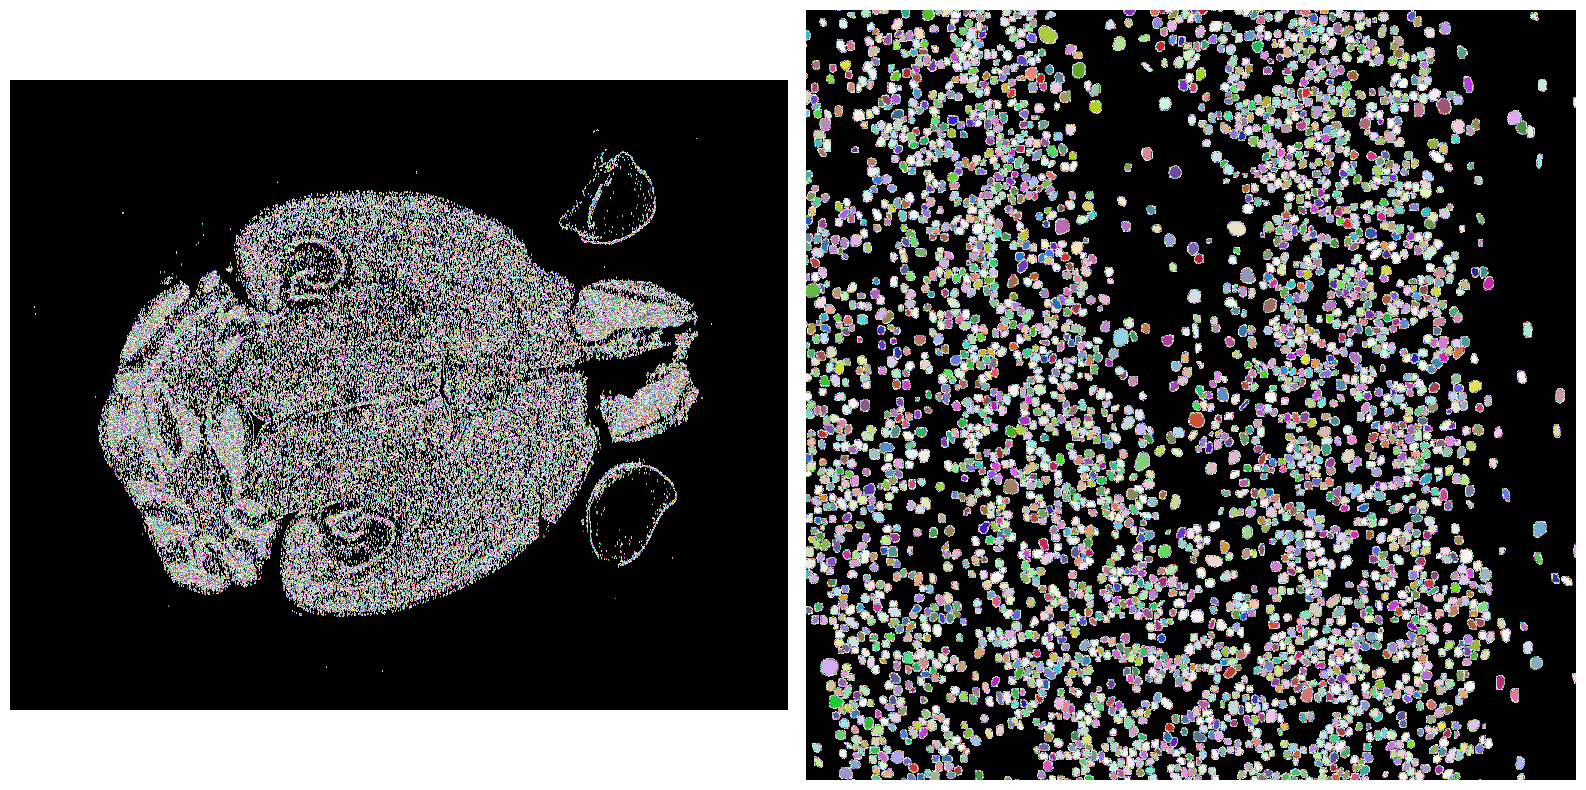

In [11]:
show_image(labels, crop_x, crop_y, tile_size, cmap=cmap)

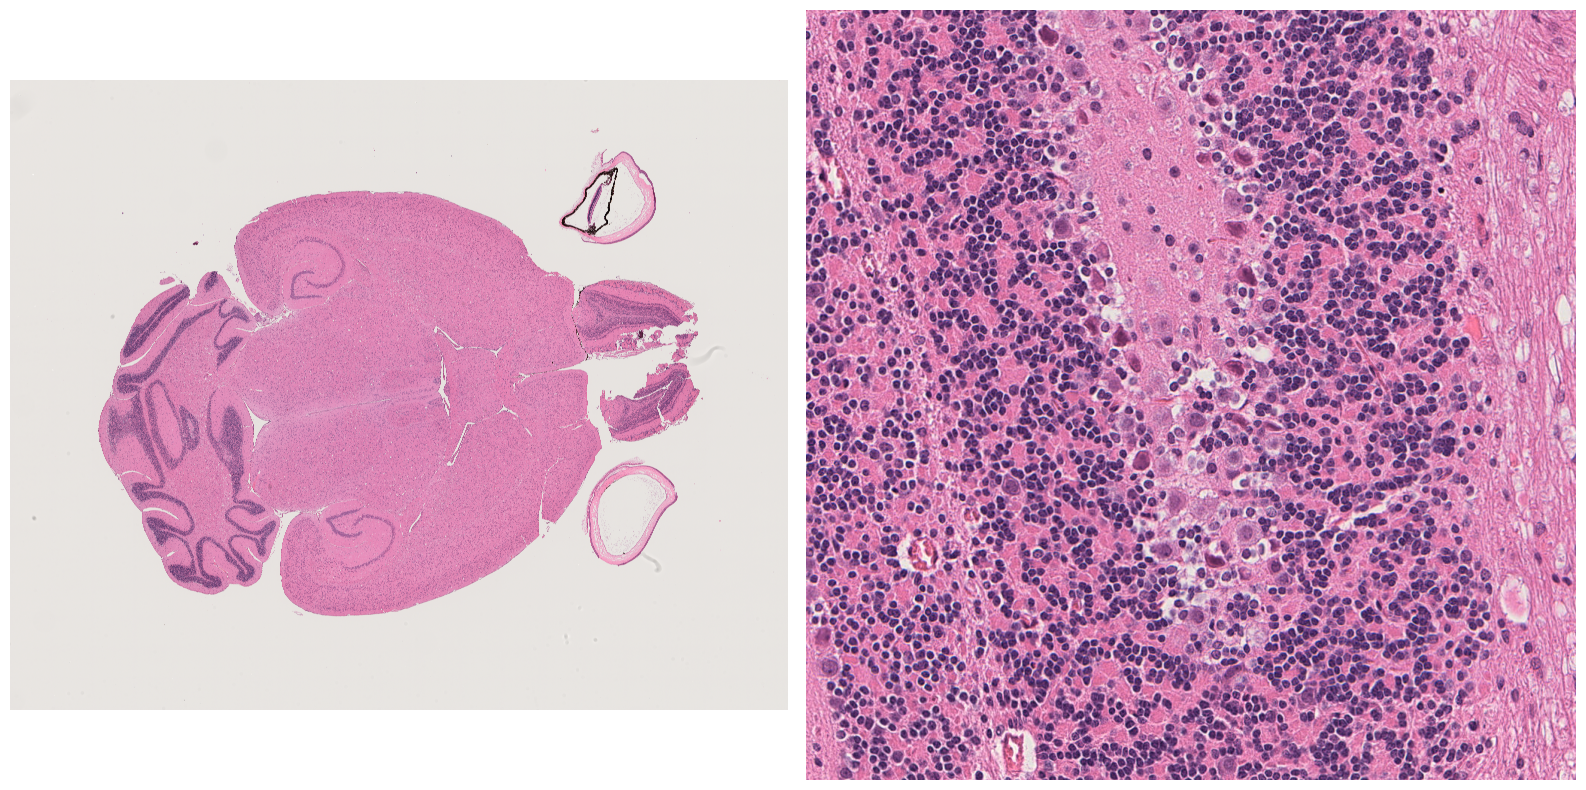

In [12]:
show_image(img, crop_x, crop_y, tile_size, cmap=cmap)

In [37]:
#cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
#cropped_lbl = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

tile_size = 512*3

y_cor = 20100
y_cor_end = y_cor + tile_size
x_cor = 14700
x_cor_end = x_cor + tile_size

cropped_img = img[y_cor:y_cor_end, x_cor:x_cor_end]
cropped_lbl = labels[y_cor:y_cor_end, x_cor:x_cor_end]

lbl_cmap = random_label_cmap()

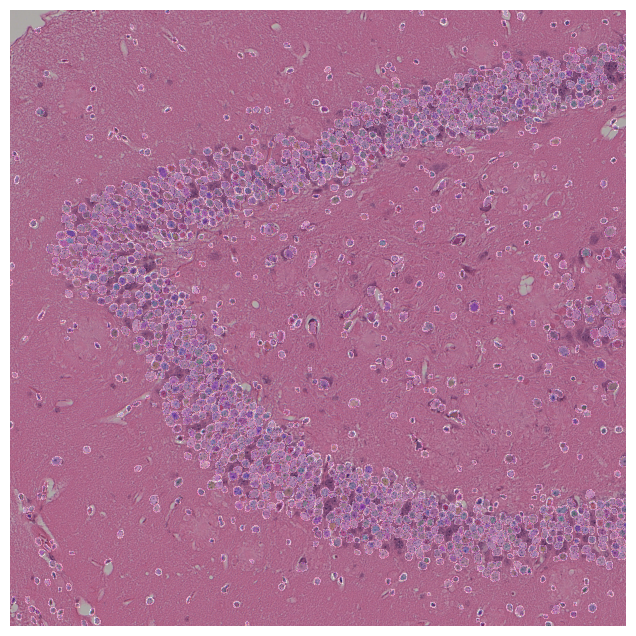

In [38]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl, cmap=lbl_cmap, alpha=0.25)
plt.axis('off')
plt.show()

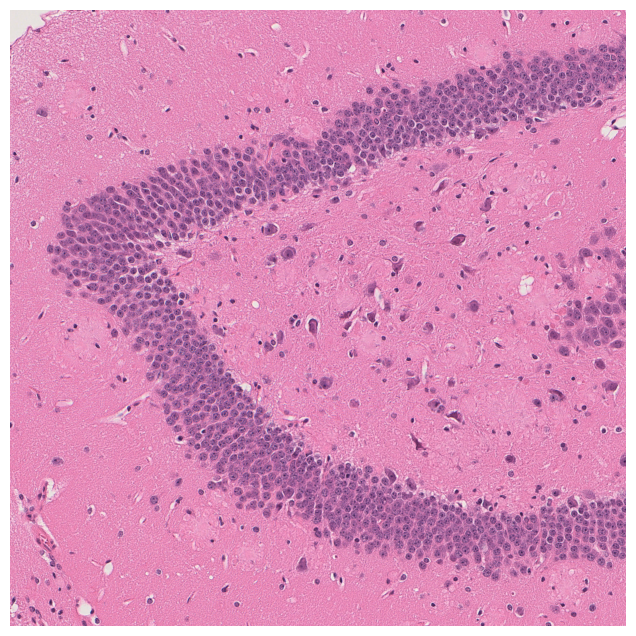

In [39]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.axis('off')
plt.show()

In [17]:
model_pre = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [18]:
labels_pre, polys_pre = model_pre.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 90/90 [02:42<00:00,  1.81s/it]


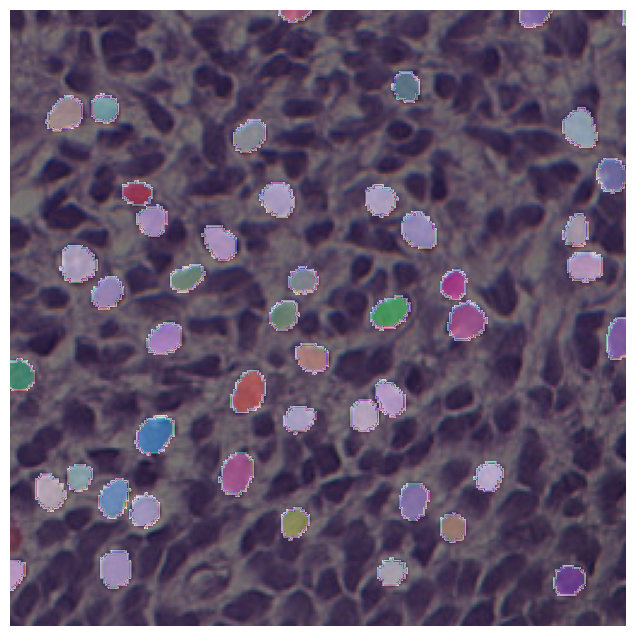

In [19]:
cropped_lbl_pre = labels_pre[y_cor:y_cor_end, x_cor:x_cor_end]

plt.figure(figsize=(8, 8))
plt.imshow(cropped_img, cmap='gray')
plt.imshow(cropped_lbl_pre, cmap=lbl_cmap, alpha=0.5)
plt.axis('off')
plt.show()

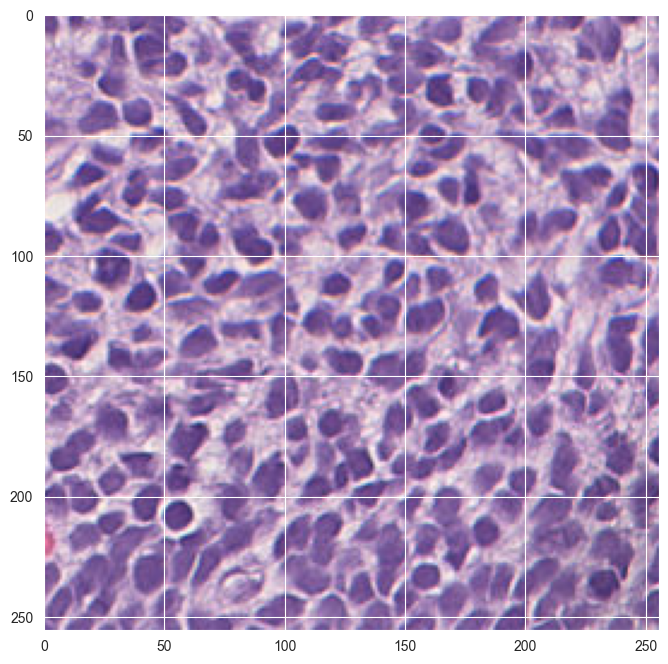

In [20]:
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img)
plt.show()

Some quantifications

In [21]:
from skimage.measure import regionprops_table
import pandas as pd

In [22]:
# Slow - takes time as we have many many objects
props = regionprops_table(labels, img,
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])


In [23]:
analysis_results = pd.DataFrame(props)
print(analysis_results.tail())

         label   area  equivalent_diameter  mean_intensity-0  \
609946  609947   41.0             7.225152          0.424868   
609947  609948   46.0             7.653040          0.527110   
609948  609949  129.0            12.815924          0.627755   
609949  609950   75.0             9.772050          0.360471   
609950  609951   82.0            10.217908          0.218651   

        mean_intensity-1  mean_intensity-2  solidity  
609946          0.499570          0.640937  0.872340  
609947          0.522762          0.683973  0.884615  
609948          0.572823          0.723332  0.977273  
609949          0.404863          0.544732  0.949367  
609950          0.221808          0.236442  0.987952  


In [24]:
import seaborn as sns

<Axes: xlabel='area', ylabel='Count'>

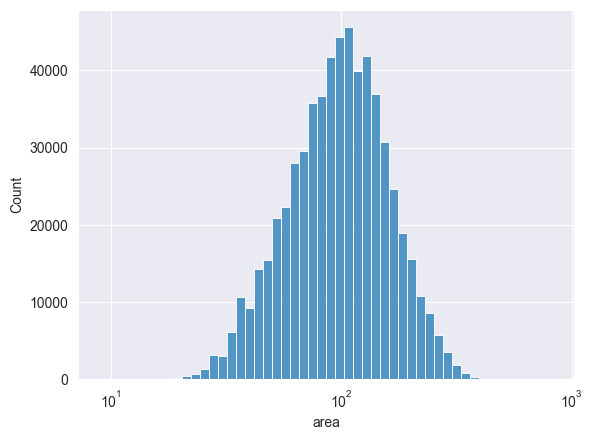

In [25]:
sns.histplot(x="area", data=analysis_results, bins=50, log_scale=True)